In [293]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn import metrics 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import RidgeCV

# Sean Lahman DB of baseball stats
conn = sqlite3.connect('lahman2016.sqlite')

In [294]:
query = '''select * from Teams 
inner join TeamsFranchises
on Teams.franchID == TeamsFranchises.franchID
where Teams.G >= 150 and TeamsFranchises.active == 'Y';
'''

# Creating dataframe from query.
Teams = conn.execute(query).fetchall()


In [295]:
teams_df = pd.DataFrame(Teams)

print(teams_df.head())

     0   1    2    3     4   5    6     7   8   9   ...        42   43   44  \
0  1961  AL  LAA  ANA  None   8  162  82.0  70  91  ...    603510  111  112   
1  1962  AL  LAA  ANA  None   3  162  81.0  86  76  ...   1144063   97   97   
2  1963  AL  LAA  ANA  None   9  161  81.0  70  91  ...    821015   94   94   
3  1964  AL  LAA  ANA  None   5  162  81.0  82  80  ...    760439   90   90   
4  1965  AL  CAL  ANA  None   7  162  80.0  75  87  ...    566727   97   98   

    45   46   47   48                             49  50    51  
0  LAA  LAA  LAA  ANA  Los Angeles Angels of Anaheim   Y  None  
1  LAA  LAA  LAA  ANA  Los Angeles Angels of Anaheim   Y  None  
2  LAA  LAA  LAA  ANA  Los Angeles Angels of Anaheim   Y  None  
3  LAA  LAA  LAA  ANA  Los Angeles Angels of Anaheim   Y  None  
4  CAL  CAL  CAL  ANA  Los Angeles Angels of Anaheim   Y  None  

[5 rows x 52 columns]


In [296]:
# Adding column names to the dataframe
cols = ['yearID','lgID','teamID','franchID','divID','Rank','G','Ghome','W','L','DivWin','WCWin','LgWin','WSWin','R','AB','H','2B','3B','HR','BB','SO','SB','CS','HBP','SF','RA','ER','ERA','CG','SHO','SV','IPouts','HA','HRA','BBA','SOA','E','DP','FP','name','park','attendance','BPF','PPF','teamIDBR','teamIDlahman45','teamIDretro','franchID','franchName','active','NAassoc']
teams_df.columns = cols

print(teams_df.head())

print(len(teams_df))

   yearID lgID teamID  franchID divID  Rank    G  Ghome   W   L   ...     \
0    1961   AL    LAA       ANA  None     8  162   82.0  70  91   ...      
1    1962   AL    LAA       ANA  None     3  162   81.0  86  76   ...      
2    1963   AL    LAA       ANA  None     9  161   81.0  70  91   ...      
3    1964   AL    LAA       ANA  None     5  162   81.0  82  80   ...      
4    1965   AL    CAL       ANA  None     7  162   80.0  75  87   ...      

  attendance  BPF  PPF teamIDBR  teamIDlahman45  teamIDretro  franchID  \
0     603510  111  112      LAA             LAA          LAA       ANA   
1    1144063   97   97      LAA             LAA          LAA       ANA   
2     821015   94   94      LAA             LAA          LAA       ANA   
3     760439   90   90      LAA             LAA          LAA       ANA   
4     566727   97   98      CAL             CAL          CAL       ANA   

                      franchName  active  NAassoc  
0  Los Angeles Angels of Anaheim       Y     N

In [297]:
# Dropping your unnecesary column variables that don't help with calculating wins.
drop_cols = ['lgID','franchID','divID','Rank','Ghome','L','DivWin','WCWin','LgWin','WSWin','SF','name','park','attendance','BPF','PPF','teamIDBR','teamIDlahman45','teamIDretro','franchID','franchName','active','NAassoc']

df = teams_df.drop(drop_cols, axis=1)

print(df.head())

   yearID teamID    G   W    R    AB     H   2B  3B   HR  ...    SHO  SV  \
0    1961    LAA  162  70  744  5424  1331  218  22  189  ...      5  34   
1    1962    LAA  162  86  718  5499  1377  232  35  137  ...     15  47   
2    1963    LAA  161  70  597  5506  1378  208  38   95  ...     13  31   
3    1964    LAA  162  82  544  5362  1297  186  27  102  ...     28  41   
4    1965    CAL  162  75  527  5354  1279  200  36   92  ...     14  33   

   IPouts    HA  HRA  BBA  SOA    E     DP     FP  
0    4314  1391  180  713  973  192  154.0  0.969  
1    4398  1412  118  616  858  175  153.0  0.972  
2    4365  1317  120  578  889  163  155.0  0.974  
3    4350  1273  100  530  965  138  168.0  0.978  
4    4323  1259   91  563  847  123  149.0  0.981  

[5 rows x 29 columns]


In [298]:
# Find all the null values
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 0, 419, 1777, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0]


In [299]:
# Elminating colums with null values that we don't need 
# caught stealing and hit by pitch
df = df.drop(['CS', 'HBP'], axis=1)

# Filling null values of Strike Outs and Double plays
# runs scored & runs allowed are cruical to predicting wins
# SO and DP aren't as important to wins so we'll fill the null values with the median 
df['SO'] = df['SO'].fillna(df['SO'].median())
df['DP'] = df['DP'].fillna(df['DP'].median())

# Ensure that you don't have anymore null values 
print(df.isnull().sum(axis=0).tolist())



[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


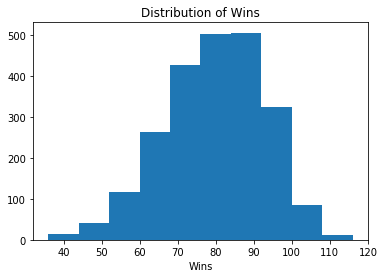

In [300]:
# Plotting the distribution of wins
plt.hist(df['W'])
plt.xlabel('Wins')
plt.title('Distribution of Wins')

plt.show()

In [301]:
#average wins per year 
print(df['W'].mean())

79.23043288150416


In [302]:
# Creating bins for the win column
# We'll use these as labels 
def assign_win_bins(W):
    if W < 50:
        return 1
    if W >= 50 and W <= 69:
        return 2
    if W >= 70 and W <= 89:
        return 3
    if W >= 90 and W <= 109:
        return 4
    if W >= 110:
        return 5
df['win_bins'] = df['W'].apply(assign_win_bins)

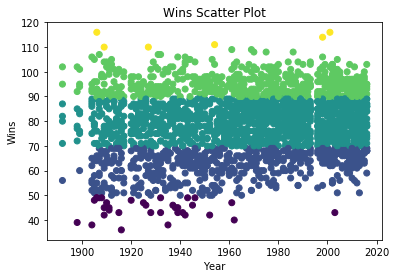

In [303]:
# Graph the year vs wins
plt.scatter(df['yearID'], df['W'], c=df['win_bins'])
plt.title("Wins Scatter Plot")
plt.xlabel('Year')
plt.ylabel('Wins')

plt.show()

In [304]:
df = df[df['yearID'] > 1900]

In [305]:
# Create runs per year and games per year dicts 
runs_per_year = {}
games_per_year = {}

for i, row in df.iterrows():
    year = row['yearID']
    runs = row['R']
    games = row['G']
    if year in runs_per_year:
#         runs_per_year[year] += runs 
#         games_per_year[year] += games 
        runs_per_year[year] = runs_per_year[year] + runs
        games_per_year[year] = games_per_year[year] + games
    else:
        runs_per_year[year] = runs 
        games_per_year[year] = games
print("Runs per year are: ", runs_per_year)
print("Games per year are: ", games_per_year)
print(len(runs_per_year))

Runs per year are:  {1961: 12942, 1962: 14461, 1963: 12780, 1964: 13124, 1965: 12946, 1966: 12900, 1967: 12210, 1968: 11109, 1969: 15850, 1970: 16880, 1971: 15073, 1972: 13706, 1973: 16376, 1974: 16046, 1975: 16295, 1976: 15492, 1977: 18803, 1978: 17251, 1979: 18713, 1980: 18053, 1982: 18110, 1983: 18170, 1984: 17921, 1985: 18216, 1986: 18545, 1987: 19883, 1988: 17380, 1989: 17405, 1990: 17919, 1991: 18127, 1992: 17341, 1993: 20864, 1996: 22831, 1997: 21604, 1998: 23297, 1999: 24691, 2000: 24971, 2001: 23199, 2002: 22408, 2003: 22978, 2004: 23376, 2005: 22325, 2006: 23599, 2007: 23322, 2008: 22585, 2009: 22419, 2010: 21308, 2011: 20808, 2012: 21017, 2013: 20255, 2014: 19761, 2015: 20647, 2016: 21744, 1904: 9307, 1905: 9640, 1906: 8322, 1907: 8186, 1908: 8423, 1909: 8805, 1910: 9580, 1911: 11164, 1912: 11154, 1913: 9964, 1914: 9408, 1915: 9444, 1916: 8889, 1917: 8948, 1920: 10762, 1921: 11935, 1922: 12059, 1923: 11874, 1924: 11722, 1925: 12596, 1926: 11443, 1927: 11745, 1928: 11645, 192

In [306]:
# MLB runs per game per year dict
mlb_runs_per_game = {}
for k, v in games_per_year.items():
    year = k
    games = v
    runs = runs_per_year[year]
    mlb_runs_per_game[year] = runs / games

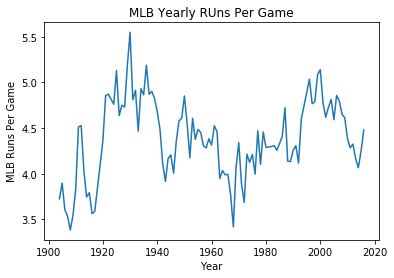

In [307]:
# Create lists from mlb runs per game dict 
lists = sorted(mlb_runs_per_game.items())
x, y = zip(*lists)

# Line plot of year vs MLB runs per game 
plt.plot(x, y)
plt.title("MLB Yearly RUns Per Game")
plt.xlabel("Year")
plt.ylabel('MLB Runs Per Game')

plt.show()

In [308]:
# Creating "year_label" column, which will give your algorithm information about how certain years are related 
# (Dead ball eras, Live ball/Steroid Eras)

def assign_label(year):
    if year < 1920:
        return 1
    elif year >= 1920 and year <= 1941:
        return 2
    elif year >= 1942 and year <= 1945:
        return 3
    elif year >= 1946 and year <= 1962:
        return 4
    elif year >= 1963 and year <= 1976:
        return 5
    elif year >= 1977 and year <= 1992:
        return 6
    elif year >= 1993 and year <= 2009:
        return 7
    elif year >= 2010:
        return 8

# Add 'year_label' column to df
df['year_label'] = df['yearID'].apply(assign_label)

dummy_df = pd.get_dummies(df['year_label'], prefix='era')

df = pd.concat([df, dummy_df], axis=1)

print(df.head())
    

   yearID teamID    G   W    R    AB     H   2B  3B   HR  ...    win_bins  \
0    1961    LAA  162  70  744  5424  1331  218  22  189  ...           3   
1    1962    LAA  162  86  718  5499  1377  232  35  137  ...           3   
2    1963    LAA  161  70  597  5506  1378  208  38   95  ...           3   
3    1964    LAA  162  82  544  5362  1297  186  27  102  ...           3   
4    1965    CAL  162  75  527  5354  1279  200  36   92  ...           3   

   year_label  era_1  era_2  era_3  era_4  era_5  era_6  era_7  era_8  
0           4      0      0      0      1      0      0      0      0  
1           4      0      0      0      1      0      0      0      0  
2           5      0      0      0      0      1      0      0      0  
3           5      0      0      0      0      1      0      0      0  
4           5      0      0      0      0      1      0      0      0  

[5 rows x 37 columns]


In [309]:
def assign_mlb_rpg(year):
    return mlb_runs_per_game[year]

df['mlb_rpg'] = df['yearID'].apply(assign_mlb_rpg)

In [310]:
# Create new column for decades 
def assign_decade(year):
    if year < 1920:
        return 1910
    elif year >= 1920 and year <= 1929:
        return 1920
    elif year >= 1930 and year <= 1939:
        return 1930
    elif year >= 1940 and year <= 1949:
        return 1940
    elif year >= 1950 and year <= 1959:
        return 1950
    elif year >= 1960 and year <= 1969:
        return 1960
    elif year >= 1970 and year <= 1979:
        return 1970
    elif year >= 1980 and year <= 1989:
        return 1980
    elif year >= 1990 and year <= 1999:
        return 1990
    elif year >= 2000 and year <= 2009:
        return 2000
    elif year >= 2010:
        return 2010

df['decade_label'] = df['yearID'].apply(assign_decade)
decade_df = pd.get_dummies(df['decade_label'], prefix='decade')
df = pd.concat([df, decade_df], axis=1)

df = df.drop(['yearID', 'year_label', 'decade_label'], axis=1)

In [311]:
# Runs per game and runs allowed per game 
df['runs_per_game'] = df['R'] / df['G']
df['runs_allowed_per_game'] = df['RA'] / df['G']



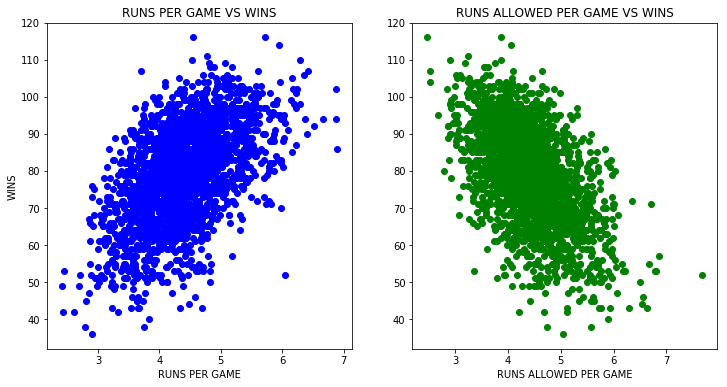

In [312]:
# Create a scatter plot for RPG vs wins and RA vs wins

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(df['runs_per_game'], df['W'], c='blue')
ax1.set_title("RUNS PER GAME VS WINS")
ax1.set_ylabel("WINS")
ax1.set_xlabel("RUNS PER GAME")


ax2.scatter(df['runs_allowed_per_game'], df['W'], c='green')
ax2.set_title("RUNS ALLOWED PER GAME VS WINS")
ax2.set_xlabel("RUNS ALLOWED PER GAME")

plt.show()

In [313]:
# Display how each variable is correlated with the target variable 
df.corr()['W']


G                        0.178958
W                        1.000000
R                        0.551504
AB                       0.233996
H                        0.380281
2B                       0.262323
3B                       0.016970
HR                       0.312713
BB                       0.345348
SO                       0.072069
SB                       0.133300
RA                      -0.518313
ER                      -0.372580
ERA                     -0.425833
CG                      -0.041788
SHO                      0.426892
SV                       0.382174
IPouts                   0.326087
HA                      -0.384893
HRA                      0.009880
BBA                     -0.284782
SOA                      0.259205
E                       -0.304725
DP                       0.015192
FP                       0.319597
win_bins                 0.912545
era_1                   -0.077104
era_2                   -0.083089
era_3                   -0.033073
era_4         

In [314]:
# Create a df that leaves out the target vars
# K-means clustering 
attributes = ['G','R','AB','H','2B','3B','HR','BB','SO','SB','RA','ER','ERA','CG',
'SHO','SV','IPouts','HA','HRA','BBA','SOA','E','DP','FP','era_1','era_2','era_3',
            'era_4','era_5','era_6','era_7','era_8','decade_1910','decade_1920',
              'decade_1930','decade_1940','decade_1950','decade_1960','decade_1970',
              'decade_1980','decade_1990','decade_2000','decade_2010','runs_per_game',
              'runs_allowed_per_game','mlb_rpg']

data_attributes = df[attributes]

print(df.head())

  teamID    G   W    R    AB     H   2B  3B   HR   BB          ...            \
0    LAA  162  70  744  5424  1331  218  22  189  681          ...             
1    LAA  162  86  718  5499  1377  232  35  137  602          ...             
2    LAA  161  70  597  5506  1378  208  38   95  448          ...             
3    LAA  162  82  544  5362  1297  186  27  102  472          ...             
4    CAL  162  75  527  5354  1279  200  36   92  443          ...             

   decade_1940  decade_1950  decade_1960  decade_1970  decade_1980  \
0            0            0            1            0            0   
1            0            0            1            0            0   
2            0            0            1            0            0   
3            0            0            1            0            0   
4            0            0            1            0            0   

   decade_1990  decade_2000  decade_2010  runs_per_game  runs_allowed_per_game  
0            0   

In [315]:
# Determine how many clusters you want 
# leverage sklearns silhouette score function 
# returns the mean silhouette coefficient over all samples 
# hint: you want a higer score
# The more clusters that added, the lower the score becomes 

s_score_dict = {}
for i in range(2, 11):
    km = KMeans(n_clusters=i, random_state=1)
    l = km.fit_predict(data_attributes)
    s_s = metrics.silhouette_score(data_attributes, l)
    s_score_dict[i] = [s_s]
    
print(s_score_dict)



{2: [0.3906998802293878], 3: [0.33807585484810926], 4: [0.25340940061017997], 5: [0.23561577404187492], 6: [0.2138869412081822], 7: [0.19570350588885863], 8: [0.1866085747852742], 9: [0.17354548788709256], 10: [0.16986446409819547]}


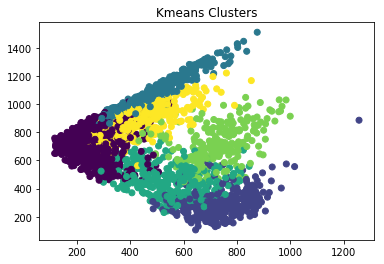

In [316]:
# Create K-means model and determine euclidian distance for each data point
kmeans_model = KMeans(n_clusters=6, random_state=1)
distances = kmeans_model.fit_transform(data_attributes)

#create scatter plot using labels from K-means model color
labels = kmeans_model.labels_

plt.scatter(distances[:,0], distances[:,1], c=labels)
plt.title("Kmeans Clusters")

plt.show()


In [317]:
# Add labels from K-means model to df and attributes list 
df['labels'] = labels
attributes.append('labels')

print(df.head())

  teamID    G   W    R    AB     H   2B  3B   HR   BB   ...    decade_1950  \
0    LAA  162  70  744  5424  1331  218  22  189  681   ...              0   
1    LAA  162  86  718  5499  1377  232  35  137  602   ...              0   
2    LAA  161  70  597  5506  1378  208  38   95  448   ...              0   
3    LAA  162  82  544  5362  1297  186  27  102  472   ...              0   
4    CAL  162  75  527  5354  1279  200  36   92  443   ...              0   

   decade_1960  decade_1970  decade_1980  decade_1990  decade_2000  \
0            1            0            0            0            0   
1            1            0            0            0            0   
2            1            0            0            0            0   
3            1            0            0            0            0   
4            1            0            0            0            0   

   decade_2010  runs_per_game  runs_allowed_per_game  labels  
0            0       4.592593               4.8

In [318]:
# split the data into train and test sets
# You don't want to train your model on the same dtat that you test the model
# The model will memorize the data instead of learning from it 
# overfitted models will perform poorly when trying to make predictions with new data 

# Create new DataFrame using only variables to be included in models
numeric_cols = ['G','R','AB','H','2B','3B','HR','BB','SO','SB','RA',
                'ER','ERA','CG','SHO','SV','IPouts','HA','HRA','BBA',
                'SOA','E','DP','FP','era_1','era_2','era_3','era_4',
                'era_5','era_6','era_7','era_8','decade_1910','decade_1920',
                'decade_1930','decade_1940','decade_1950','decade_1960','decade_1970',
                'decade_1980','decade_1990','decade_2000','decade_2010','runs_per_game',
                'runs_allowed_per_game','mlb_rpg','labels','W']

data = df[numeric_cols]
print(data.head())

#split df into train and test sets 
train = data.sample(frac=0.75, random_state=1)
test = data.loc[~data.index.isin(train.index)]

x_train = train[attributes]
y_train = train['W']
x_test = test[attributes]
y_test = test['W']



     G    R    AB     H   2B  3B   HR   BB      SO   SB ...  decade_1970  \
0  162  744  5424  1331  218  22  189  681  1068.0   37 ...            0   
1  162  718  5499  1377  232  35  137  602   917.0   46 ...            0   
2  161  597  5506  1378  208  38   95  448   916.0   43 ...            0   
3  162  544  5362  1297  186  27  102  472   920.0   49 ...            0   
4  162  527  5354  1279  200  36   92  443   973.0  107 ...            0   

   decade_1980  decade_1990  decade_2000  decade_2010  runs_per_game  \
0            0            0            0            0       4.592593   
1            0            0            0            0       4.432099   
2            0            0            0            0       3.708075   
3            0            0            0            0       3.358025   
4            0            0            0            0       3.253086   

   runs_allowed_per_game   mlb_rpg  labels   W  
0               4.839506  4.525175       5  70  
1           

In [319]:
# Selecting Error Metric and Model 

# Mean Absolute Error (MAE) is the metric used to determine how accurate the model is 
# Measures how close predictions are to eventual outcomes 
# If, on average, the prediction misses the target amount by 5 wins, the error metric will be 5

# Creating the linear regrssion model, fit model, and make the predictions
lr = LinearRegression(normalize=True)
lr.fit(x_train, y_train)
predictions = lr.predict(x_test)

#determine mean absolute error
mae = mean_absolute_error(y_test, predictions)

print(mae)
# 2.68986721511


# If you recall from above, the average number of wins was about 79 wins. 
#On average, the model is off by only 2.687 wins.

2.688790228995918


In [320]:
# Create ridge linear regression model, fit model, make predicitions 
rrm = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0), normalize=True)
rrm.fit(x_train, y_train)
predictions_rrm = rrm.predict(x_test)

# Determine mean absolute error 
mae_rrm = mean_absolute_error(y_test, predictions_rrm)
print(mae_rrm)
# 2.6725918746463044

#This model performed slightly better, 
# and is off by 2.673 wins, on average.


2.6725918746463044
